In [7]:
import numpy as np
import random

class GridWorld:
    # call to initialize grid world enviroment, default will be a 5x5 grid with a start point at the top left corner and goal at
    # the bottom right corner, no obsticals, if probablity of obsticals is given, these will be placed in enviroment randomly
    def __init__(self, grid_size=(5, 5), start_point=(0, 0), goal_point=None, prob_obstacle=0):
        self.grid_size = grid_size
        self.start_point = start_point
        self.goal_point = goal_point if goal_point is not None else (grid_size[0] - 1, grid_size[1] - 1)
        self.prob_obstacle = prob_obstacle

        self.action_map = ['up', 'down', 'left', 'right']
        self.reset()

    def reset(self):
        self.agent_point = self.start_point
        self.grid = np.zeros(self.grid_size, dtype=int)  # 0 for free, 1 for obstacle

        if self.prob_obstacle > 0:
            for r in range(self.grid_size[0]):
                for c in range(self.grid_size[1]):
                    if random.random() < self.prob_obstacle and (r, c) != self.start_point and (r, c) != self.goal_point:
                        self.grid[r, c] = 1

        return self.agent_point

    def step(self, action_idx):
        action = self.action_map[action_idx]
        x, y = self.agent_point
        next_x, next_y = x, y

        if action == 'up' and x > 0:
            next_x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            next_x += 1
        elif action == 'left' and y > 0:
            next_y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            next_y += 1

        # If next cell is an obstacle, stay in place
        if self.grid[next_x, next_y] == 1:
            next_x, next_y = x, y

        self.agent_point = (next_x, next_y)
        done = self.is_at_goal()
        reward = 10 if done else -1
        return self.agent_point, reward, done, {}

    def is_at_goal(self):
        return self.agent_point == self.goal_point


In [8]:
class QLearningAgent:
    def __init__(self, grid_size, action_size=4, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        """
        Initialize the Q-learning agent.
        Args:
            grid_size: Size of the grid (grid_size x grid_size)
            action_size: Size of the action space (default 4: up, right, down, left)
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Decay rate for exploration
        """
        
        self.grid_size = grid_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table with zeros
        # Q-table shape: (grid_size, grid_size, action_size)

        self.q_table = np.zeros((grid_size[0], grid_size[1], action_size))

    def get_action(self, state, training=True):
        """
        Get action for the given state using epsilon-greedy policy.
        Args:
            state: Current state (x, y)
            training: Whether we're in training mode (use epsilon-greedy) or not
        Returns:
            action: Selected action
        """
        x, y = state
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # Exploration: choose a random action
        else:
            return np.argmax(self.q_table[x, y])        # Exploitation: choose the best action from Q-table

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-table using the Q-learning update rule.
        Args:
            state: Current state (x, y)
            action: Action taken
            reward: Reward received
            next_state: Next state (x, y)
            done: Whether the episode is done
        """
        x, y = state
        next_x, next_y = next_state
        
        # Q-learning update rule
        # Q(s,a) = Q(s,a) + alpha * [r + gamma * max(Q(s',a')) - Q(s,a)]
        
        if not done:
            target = reward + self.gamma * np.max(self.q_table[next_x, next_y])
        else:
            target = reward
            
        current = self.q_table[x, y, action]
        self.q_table[x, y, action] = current + self.alpha * (target - current)

    def decay_epsilon(self):
        """Decay exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [29]:
import os
import time

def train(env, agent, episodes=500, max_steps=100):
    """
    Train the agent in the environment.
    Args:
        env: GridWorldEnv instance
        agent: QLearningAgent instance
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
    """

    rewards = []
    steps_list = []
    start_time = time.time()

    for episode in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            action = agent.get_action(state)                         # Get action
            next_state, reward, done, _ = env.step(action)           # Take step
            agent.update(state, action, reward, next_state, done)    # Update Q-table

            # Update state and total reward
            state = next_state
            total_reward += reward

            if done:
                break

        # Decay exploration rate
        agent.decay_epsilon()
        
        # Save rewards and steps
        rewards.append(total_reward)
        steps_list.append(step + 1)

        log_interval=100
        # Log progress
        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_steps = np.mean(steps_list[-log_interval:])
            print(f"Episode {episode}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Epsilon: {agent.epsilon:.4f}")

    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")

    return rewards, steps_list

In [30]:
if __name__ == '__main__':
    # Initialize environment and agent
    env = GridWorld(grid_size=(5, 5), prob_obstacle=0.2)  # 20% obstacle probability
    agent = QLearningAgent(grid_size=env.grid_size)

    # Train
    train(env, agent, episodes=1000)

Episode 100/1000 | Avg Reward: -42.91 | Avg Steps: 51.38 | Epsilon: 0.6058
Episode 200/1000 | Avg Reward: -31.57 | Avg Steps: 40.26 | Epsilon: 0.3670
Episode 300/1000 | Avg Reward: -34.65 | Avg Steps: 42.90 | Epsilon: 0.2223
Episode 400/1000 | Avg Reward: -43.77 | Avg Steps: 51.03 | Epsilon: 0.1347
Episode 500/1000 | Avg Reward: -29.75 | Avg Steps: 38.55 | Epsilon: 0.0816
Episode 600/1000 | Avg Reward: -39.40 | Avg Steps: 47.10 | Epsilon: 0.0494
Episode 700/1000 | Avg Reward: -40.67 | Avg Steps: 48.26 | Epsilon: 0.0299
Episode 800/1000 | Avg Reward: -39.76 | Avg Steps: 47.68 | Epsilon: 0.0181
Episode 900/1000 | Avg Reward: -47.01 | Avg Steps: 54.16 | Epsilon: 0.0110
Episode 1000/1000 | Avg Reward: -45.63 | Avg Steps: 53.22 | Epsilon: 0.0100

Training completed in 1.49 seconds.


In [24]:
def evaluate(env, agent, episodes=10, max_steps=100, render=True):
    rewards, steps_list, success_count = [], [], 0
    for ep in range(episodes):
        state, total_reward, done = env.reset(), 0, False
        path = [state]
        for step in range(max_steps):
            action = agent.get_action(state, training=False)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(state)
            total_reward += reward
            if done:
                if reward > 0: success_count += 1
                break
        rewards.append(total_reward)
        steps_list.append(step + 1)
        if render and ep == 0:
            visualize_path(env, path)
        print(f"Episode {ep+1}/{episodes} | Reward: {total_reward} | Steps: {step + 1}")
    print(f"\nSuccess Rate: {success_count / episodes * 100:.2f}%")
    return rewards, steps_list

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_training_progress(rewards, steps):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Rewards per Episode")
    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.title("Steps per Episode")
    plt.savefig('training_progress.png')
    plt.show()

Episode 100/100 | Avg Reward: -85.46 | Avg Steps: 88.76 | Epsilon: 0.6058

Training completed in 0.28 seconds.


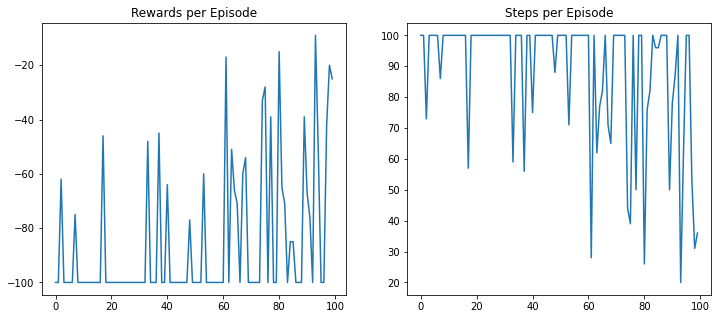

In [26]:
import argparse

def main(args=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', choices=['train', 'evaluate', 'visualize'], default='train')
    parser.add_argument('--grid_size', type=int, default=5)
    parser.add_argument('--obstacle_ratio', type=float, default=0.2)
    parser.add_argument('--episodes', type=int, default=1000)
    parser.add_argument('--max_steps', type=int, default=100)
    parser.add_argument('--alpha', type=float, default=0.1)
    parser.add_argument('--gamma', type=float, default=0.99)
    parser.add_argument('--epsilon', type=float, default=1.0)
    parser.add_argument('--epsilon_min', type=float, default=0.01)
    parser.add_argument('--epsilon_decay', type=float, default=0.995)

    if args is None:
        args = []
    args = parser.parse_args(args)

    env = GridWorld(grid_size=(args.grid_size, args.grid_size), prob_obstacle=args.obstacle_ratio)
    agent = QLearningAgent(grid_size=(args.grid_size, args.grid_size),
                           alpha=args.alpha, gamma=args.gamma,
                           epsilon=args.epsilon, epsilon_min=args.epsilon_min,
                           epsilon_decay=args.epsilon_decay)

    if args.mode == 'train':
        rewards, steps = train(env, agent, episodes=args.episodes, max_steps=args.max_steps)
        plot_training_progress(rewards, steps)

    elif args.mode == 'evaluate':
        agent.load_model(args.model_path)
        evaluate(env, agent, episodes=10, max_steps=args.max_steps)


if __name__ == "__main__":
    main(['--mode', 'train','--grid_size', '8', '--episodes', '100'])